In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
arma_data = {'kenya':["./Output_kenya_2021/synthetic.csv", "../data/"]}

case = "kenya"

if case not in arma_data.keys():
  raise KeyError("{}, Case not in dictionary".format(case))
filename = arma_data[case][0]
data_dir = arma_data[case][1]

synthetic_df = pd.read_csv(filename)
tag = filename.split('/')[1][7:]
synthetic_df.head()
#only keep first 4 years of data
synthetic_df = synthetic_df[synthetic_df['Year']<=2021]
# Remove useless data
synthetic_df.drop(columns=['scaling', 'RAVEN_sample_ID','prefix', 'PointProbability', 'ProbabilityWeight'], inplace=True)
synthetic_df.rename({'price':'synthetic price'}, axis=1, inplace=True)
print(tag)
synthetic_df

kenya_2021


,hour,Year,synthetic price
0,1,2021,0.016672
30,2,2021,0.017170
60,3,2021,0.023328
90,4,2021,0.023028
120,5,2021,0.022401
...,...,...,...
261930,8732,2021,0.016487
261960,8733,2021,0.014450
261990,8734,2021,0.016029
262020,8735,2021,0.015510


In [6]:
# Get year list from synthetic data
years_list  = synthetic_df.Year.unique()
print(years_list)
files_names = os.listdir(data_dir)
li = []
for f in files_names: 
  if f.endswith('csv') and 'historical' not in f:
    year = int(f.split('_')[0])
    if year in years_list:
      file = data_dir+f
      df = pd.read_csv(file)
      df['Year'] = [year for i in range(len(df))]
      li.append(df)
hist_df = pd.concat(li, axis=0, ignore_index=True)
hist_df.rename({'price':'historical price'}, axis=1,inplace=True)
hist_df.to_csv(os.path.join(data_dir,"historical_prices.csv"),index=False)

[2021]


Merge historical and synthetic data

In [7]:
sum_df = pd.merge(hist_df, synthetic_df, how='inner')
sum_df

,hour,historical price,Year,synthetic price
0,1,0.0166,2021,0.016672
1,2,0.0175,2021,0.017170
2,3,0.0188,2021,0.023328
3,4,0.0201,2021,0.023028
4,5,0.0199,2021,0.022401
...,...,...,...,...
8731,8732,0.0155,2021,0.016487
8732,8733,0.0150,2021,0.014450
8733,8734,0.0154,2021,0.016029
8734,8735,0.0163,2021,0.015510


In [9]:
# Statistic summary
temp_df = sum_df.drop(columns=['Year','hour'])
stats = dict(temp_df.describe())
#stats_df.append() = temp_df.kurtosis(axis=0)
for k,v in stats.items(): 
  stats[k] = dict(v)
#stats['historical price'] = dict(stats['historical price'])
# Add kurtosis
stats['historical price']['kurtosis'] = float(hist_df['historical price'].kurtosis(axis = 0))
stats['synthetic price']['kurtosis'] = float(synthetic_df['synthetic price'].kurtosis(axis = 0))
# Add skewness
stats['historical price']['skewness'] = float(hist_df['historical price'].skew(axis = 0))
stats['synthetic price']['skewness'] = float(synthetic_df['synthetic price'].skew(axis = 0))
stats_df = pd.DataFrame(stats)
print(tag)
with pd.ExcelWriter('ARMA_stats.xlsx',mode='a', if_sheet_exists='replace') as writer:  
    stats_df.to_excel(writer, sheet_name=tag, )
stats_df

kenya_2021


,historical price,synthetic price
count,8736.000000,8736.000000
mean,0.020142,0.020139
std,0.004933,0.004924
min,0.011900,0.011900
25%,0.016375,0.016339
50%,0.019300,0.019315
75%,0.022700,0.022722
max,0.037100,0.037100
kurtosis,0.593385,0.587671
skewness,0.920387,0.916965


In [10]:
# Concatenate historic and synthetic prices with a tag
temp_hist = hist_df.drop(columns=['Year', 'hour']).rename({'historical price':'price'}, axis=1)
temp_synth = synthetic_df.drop(columns=['Year', 'hour']).rename({'synthetic price':'price'}, axis=1)
pieces = {'historical': temp_hist, 'synthetic':temp_synth}
prices_df = pd.concat(pieces, names=["type"])
prices_df = prices_df.reset_index(level=0)
prices_df

,type,price
0,historical,0.016600
1,historical,0.017500
2,historical,0.018800
3,historical,0.020100
4,historical,0.019900
...,...,...
261930,synthetic,0.016487
261960,synthetic,0.014450
261990,synthetic,0.016029
262020,synthetic,0.015510


0.0371 0.0227 0.016375 0.0119


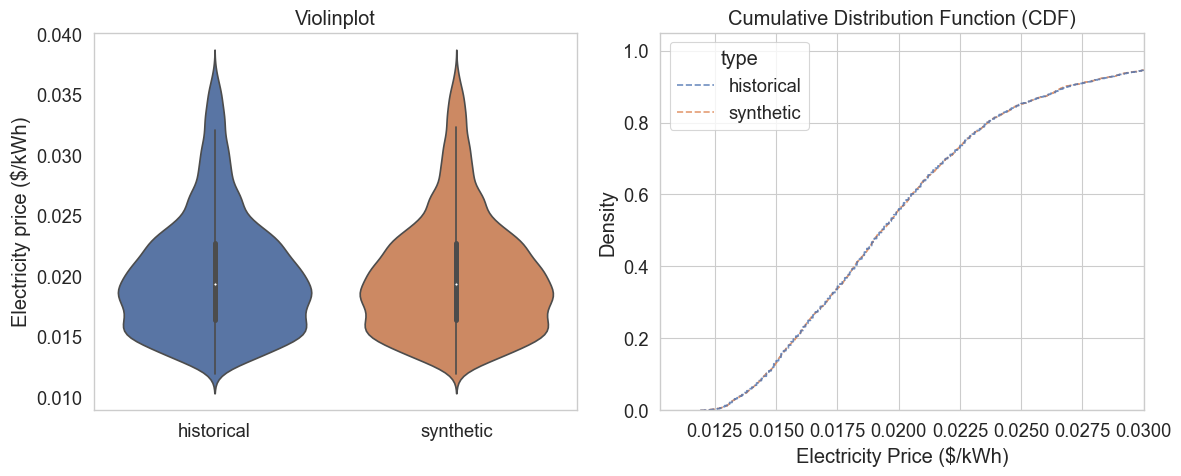

In [12]:
# Plot and save histograms and boxplots
fig, axes = plt.subplots(1,2,figsize =(12,5))

title = ' '.join(tag.split('_')).upper()+'\n Comparison of historical and synthetic data'
#fig.suptitle(title, y = 1.07)

mean  = stats['historical price']['mean']
price95 = 2*stats['historical price']['std']+mean
price05 = mean -2*stats['historical price']['std']
max_price = stats['historical price']['max']
quart1_price = stats['historical price']['25%']
min_price = stats['historical price']['min']
quart3_price = stats['historical price']['75%']
print(max_price, quart3_price, quart1_price, min_price)

sns.set_theme(style='whitegrid')
sns.set_context("paper", font_scale=1.5)

sns.violinplot(ax = axes[0],data=prices_df, x='type', y='price', alpha=0.8)

axes[0].set_title('Violinplot')
axes[0].set_ylabel('Electricity price ($/kWh)')
axes[0].set_xlabel('')
axes[0].grid(axis='y')

sns.histplot(ax = axes[1], data=prices_df, x='price', hue='type', linestyle = "dashed", alpha=0.8,bins=len(prices_df), stat='density', element='step', fill=False,cumulative=True, common_norm=False)
axes[1].set_title('Cumulative Distribution Function (CDF)')
axes[1].set_xlabel('Electricity Price ($/kWh)')
axes[1].set_xlim(price05,price95)

fig.tight_layout()
fig.savefig(tag+'_comparison_plots.png')

